In [9]:
import shap
import cv2
from PIL import Image
import dataFrameTools
import numpy as np
from pathlib import Path
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

In [2]:
df=dataFrameTools.normalizeDF(0)
reduced=pd.read_csv("../Data/BIKED_reduced.csv", index_col=0)
reduced.BIKESTYLE=pd.Categorical(reduced.BIKESTYLE)
df['BIKESTYLE']=reduced.BIKESTYLE.cat.codes

#Drop classes with few models
cutoff=0
vcounts=reduced["BIKESTYLE"].value_counts()
df = df[reduced['BIKESTYLE'].isin(list(vcounts[vcounts>=cutoff].index))]
classes=vcounts[vcounts>=cutoff].index
orderedclasses=vcounts.index

classes=sorted(reduced["BIKESTYLE"].unique())

images=[]
for i in df.index.values:
    filePath=Path("../Processed Images/Grayscale/(" + str(i) + ").png")
    image=cv2.imread(str(filePath),0)
#     image = np.array(Image.open(filePath))
    images.append(image)
images=np.array(images)
#scale image values
images=images/255.0
split = train_test_split(df, images, test_size=0.3, random_state=42)
dtrain, dtv, itrain, itv = split
dtest, dval, itest, ival = train_test_split(dtv, itv, test_size=0.5, random_state=42)
itrain=tf.expand_dims(itrain, -1)
ival=tf.expand_dims(ival, -1)
itest=tf.expand_dims(itest, -1)

classes=sorted(reduced["BIKESTYLE"].unique())
print(classes)
ytrain=dtrain["BIKESTYLE"]
yval=dval["BIKESTYLE"]
ytest=dtest["BIKESTYLE"]
dtest=dtest.drop("BIKESTYLE", axis=1)
dval=dval.drop("BIKESTYLE", axis=1)
dtrain=dtrain.drop("BIKESTYLE", axis=1)
imdims=np.shape(itrain[1])
ddims=len(dtrain.columns)
ydims=max(df["BIKESTYLE"])+1

Loaded Imputed Dataframe in  0.8046910762786865 seconds
['BMX', 'CARGO', 'CHILDRENS', 'CITY', 'COMMUTER', 'CRUISER', 'CYCLOCROSS', 'DIRT_JUMP', 'FAT', 'GRAVEL', 'HYBRID', 'MTB', 'OTHER', 'POLO', 'ROAD', 'TIMETRIAL', 'TOURING', 'TRACK', 'TRIALS']


In [3]:
def create_cnn(imdims, ydims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=imdims))
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(200, name="e3"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
#     model.add(layers.Dense(200, name="e4"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(ydims, name="e5"))
    model.add(layers.Softmax())
    return model
def create_dnn(ddims, ydims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=ddims))
    
    model.add(layers.Dense(200, name="e1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(200, name="e2"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(200, name="e3"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(200, name="e4"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
#     model.add(layers.Dense(200, name="e5"))
#     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())
#     model.add(layers.ReLU())
#     model.add(layers.Dropout(0.2))
    
#     model.add(layers.Dense(200, name="e6"))
#     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())
#     model.add(layers.ReLU())
#     model.add(layers.Dropout(0.2))
    
    
    model.add(layers.Dense(ydims, name="e7"))
    model.add(layers.Softmax())
    return model

def comb_cnn(imdims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=imdims))
#     model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="c1"))
    model.add(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="c1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="c2"))
    model.add(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="c2"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    
#     model.add(layers.Dense(200, name="c4"))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    return model

def comb_dnn(ddims):
    model=tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=ddims))
    
    model.add(layers.Dense(200, name="d1"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    
#     model.add(layers.Dense(200, name="d2"))
#     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())
#     model.add(layers.ReLU())
#     model.add(layers.Dropout(0.3))
    
#     model.add(layers.Dense(200, name="d3"))
# #     model.add(layers.LeakyReLU())
#     model.add(layers.ReLU())
#     model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(200, name="d4"))
    model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))
    return model

def create_comb(comb_input,ydims):
    imdims=comb_input[0]
    ddims=comb_input[1]
    cnn=comb_cnn(imdims)
    dnn=comb_dnn(ddims)
    combinedInput=concatenate([cnn.output, dnn.output])
    x=layers.Dense(200, name="f1")(combinedInput)
    x=layers.BatchNormalization()(x)
#     x=layers.LeakyReLU()(x)
    x=layers.ReLU()(x)
    x=layers.Dropout(0.3)(x)
#     x=layers.Dense(ydims, name="f2")(x)
#     x=layers.BatchNormalization()(x)
#     x=layers.LeakyReLU()(x)
#     x=layers.Dropout(0.3)(x)
    x=layers.Dense(ydims, name="f3")(x)
#     x=layers.Dense(ydims, name="f2")(combinedInput)
    model=Model(inputs=[cnn.input, dnn.input], outputs=x)
    return model


In [13]:
st=time.time()
maxacc=0
average=0
numtests=1
scores=np.zeros(4)
topscores=np.copy(scores)
score=np.copy(scores)
for i in range(numtests):
    dnnmodel=create_dnn(ddims, ydims)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    dnnmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = dnnmodel.fit(x=dtrain, y=ytrain, epochs=1000, batch_size=100, validation_data=(dval, yval), callbacks=[callback])
    y_pred=tf.argmax(input=dnnmodel.predict(dtest), axis=1).numpy()[np.newaxis].T
    score[0]=accuracy_score(ytest,y_pred)
    score[1]=recall_score(ytest,y_pred, average='macro', zero_division=0)
    score[2]=precision_score(ytest,y_pred, average='macro', zero_division=0)
    score[3]=f1_score(ytest,y_pred, average='macro')
    for i in range(len(score)):
        if score[i]>topscores[i]:
            topscores[i]=score[i]
            dnnhistory=history
            bestdnn=dnnmodel
    scores=[scores[i]+score[i]/numtests for i in range(len(score))]
print(scores)
print(topscores)
print(" evaluation time: " + str((time.time() - st)))

Epoch 1/1000
32/32 [==============================] - 1s 12ms/step - loss: 2.9358 - accuracy: 0.0769 - val_loss: 2.9404 - val_accuracy: 0.2157
Epoch 2/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.9018 - accuracy: 0.1675 - val_loss: 2.9303 - val_accuracy: 0.3634
Epoch 3/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.8365 - accuracy: 0.2954 - val_loss: 2.9068 - val_accuracy: 0.4003
Epoch 4/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.7384 - accuracy: 0.4060 - val_loss: 2.8450 - val_accuracy: 0.4446
Epoch 5/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.6436 - accuracy: 0.4908 - val_loss: 2.7435 - val_accuracy: 0.4668
Epoch 6/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.5793 - accuracy: 0.5244 - val_loss: 2.6587 - val_accuracy: 0.4978
Epoch 7/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.5409 - accuracy: 0.5548 - val_loss: 2.5984 - val_accuracy: 0.5185
Epoch

32/32 [==============================] - 0s 8ms/step - loss: 2.2976 - accuracy: 0.7359 - val_loss: 2.3960 - val_accuracy: 0.6352
Epoch 59/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2971 - accuracy: 0.7350 - val_loss: 2.3954 - val_accuracy: 0.6381
Epoch 60/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2958 - accuracy: 0.7359 - val_loss: 2.3964 - val_accuracy: 0.6337
Epoch 61/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2945 - accuracy: 0.7391 - val_loss: 2.3976 - val_accuracy: 0.6322
Epoch 62/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2916 - accuracy: 0.7413 - val_loss: 2.3915 - val_accuracy: 0.6411
Epoch 63/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2925 - accuracy: 0.7410 - val_loss: 2.3892 - val_accuracy: 0.6425
Epoch 64/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2914 - accuracy: 0.7438 - val_loss: 2.3875 - val_accuracy: 0.6470
Epoch 65/1000

32/32 [==============================] - 0s 8ms/step - loss: 2.2230 - accuracy: 0.8097 - val_loss: 2.3652 - val_accuracy: 0.6647
Epoch 116/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2224 - accuracy: 0.8106 - val_loss: 2.3660 - val_accuracy: 0.6677
Epoch 117/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2236 - accuracy: 0.8087 - val_loss: 2.3625 - val_accuracy: 0.6662
Epoch 118/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2239 - accuracy: 0.8091 - val_loss: 2.3603 - val_accuracy: 0.6750
Epoch 119/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2236 - accuracy: 0.8091 - val_loss: 2.3575 - val_accuracy: 0.6736
Epoch 120/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2208 - accuracy: 0.8119 - val_loss: 2.3597 - val_accuracy: 0.6706
Epoch 121/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2192 - accuracy: 0.8132 - val_loss: 2.3608 - val_accuracy: 0.6706
Epoch 1

Epoch 172/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2035 - accuracy: 0.8309 - val_loss: 2.3514 - val_accuracy: 0.6795
Epoch 173/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2017 - accuracy: 0.8303 - val_loss: 2.3528 - val_accuracy: 0.6780
Epoch 174/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.2031 - accuracy: 0.8293 - val_loss: 2.3540 - val_accuracy: 0.6809
Epoch 175/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1991 - accuracy: 0.8357 - val_loss: 2.3544 - val_accuracy: 0.6750
Epoch 176/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1976 - accuracy: 0.8341 - val_loss: 2.3493 - val_accuracy: 0.6824
Epoch 177/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1974 - accuracy: 0.8369 - val_loss: 2.3541 - val_accuracy: 0.6765
Epoch 178/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1980 - accuracy: 0.8363 - val_loss: 2.3527 - val_accuracy:

Epoch 229/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1576 - accuracy: 0.8771 - val_loss: 2.3262 - val_accuracy: 0.7061
Epoch 230/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1572 - accuracy: 0.8778 - val_loss: 2.3159 - val_accuracy: 0.7149
Epoch 231/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1552 - accuracy: 0.8775 - val_loss: 2.3108 - val_accuracy: 0.7238
Epoch 232/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1570 - accuracy: 0.8784 - val_loss: 2.3058 - val_accuracy: 0.7267
Epoch 233/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1556 - accuracy: 0.8797 - val_loss: 2.3076 - val_accuracy: 0.7297
Epoch 234/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1559 - accuracy: 0.8794 - val_loss: 2.3145 - val_accuracy: 0.7134
Epoch 235/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1527 - accuracy: 0.8819 - val_loss: 2.3075 - val_accuracy:

Epoch 286/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1435 - accuracy: 0.8882 - val_loss: 2.3005 - val_accuracy: 0.7326
Epoch 287/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1423 - accuracy: 0.8898 - val_loss: 2.2982 - val_accuracy: 0.7356
Epoch 288/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1455 - accuracy: 0.8860 - val_loss: 2.3001 - val_accuracy: 0.7326
Epoch 289/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1445 - accuracy: 0.8876 - val_loss: 2.2993 - val_accuracy: 0.7356
Epoch 290/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1442 - accuracy: 0.8876 - val_loss: 2.3001 - val_accuracy: 0.7267
Epoch 291/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1429 - accuracy: 0.8889 - val_loss: 2.3010 - val_accuracy: 0.7341
Epoch 292/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1457 - accuracy: 0.8863 - val_loss: 2.3018 - val_accuracy:

Epoch 343/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1265 - accuracy: 0.9056 - val_loss: 2.3012 - val_accuracy: 0.7297
Epoch 344/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1297 - accuracy: 0.9018 - val_loss: 2.3038 - val_accuracy: 0.7297
Epoch 345/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1281 - accuracy: 0.9041 - val_loss: 2.2892 - val_accuracy: 0.7445
Epoch 346/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1277 - accuracy: 0.9050 - val_loss: 2.2902 - val_accuracy: 0.7386
Epoch 347/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1287 - accuracy: 0.9044 - val_loss: 2.2896 - val_accuracy: 0.7400
Epoch 348/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1269 - accuracy: 0.9047 - val_loss: 2.2868 - val_accuracy: 0.7474
Epoch 349/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1274 - accuracy: 0.9060 - val_loss: 2.2956 - val_accuracy:

Epoch 400/1000
32/32 [==============================] - 0s 9ms/step - loss: 2.1201 - accuracy: 0.9126 - val_loss: 2.2910 - val_accuracy: 0.7445
Epoch 401/1000
32/32 [==============================] - 0s 9ms/step - loss: 2.1183 - accuracy: 0.9139 - val_loss: 2.2928 - val_accuracy: 0.7386
Epoch 402/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1192 - accuracy: 0.9132 - val_loss: 2.2972 - val_accuracy: 0.7415
Epoch 403/1000
32/32 [==============================] - 0s 9ms/step - loss: 2.1155 - accuracy: 0.9186 - val_loss: 2.2967 - val_accuracy: 0.7356
Epoch 404/1000
32/32 [==============================] - 0s 9ms/step - loss: 2.1170 - accuracy: 0.9158 - val_loss: 2.2892 - val_accuracy: 0.7459
Epoch 405/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1168 - accuracy: 0.9180 - val_loss: 2.2907 - val_accuracy: 0.7459
Epoch 406/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1160 - accuracy: 0.9167 - val_loss: 2.2976 - val_accuracy:

Epoch 457/1000
32/32 [==============================] - 0s 9ms/step - loss: 2.1066 - accuracy: 0.9275 - val_loss: 2.2935 - val_accuracy: 0.7400
Epoch 458/1000
32/32 [==============================] - 0s 9ms/step - loss: 2.1038 - accuracy: 0.9288 - val_loss: 2.2936 - val_accuracy: 0.7371
Epoch 459/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1037 - accuracy: 0.9297 - val_loss: 2.2962 - val_accuracy: 0.7341
Epoch 460/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1059 - accuracy: 0.9269 - val_loss: 2.3122 - val_accuracy: 0.7238
Epoch 461/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1031 - accuracy: 0.9303 - val_loss: 2.2992 - val_accuracy: 0.7326
Epoch 462/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.1022 - accuracy: 0.9307 - val_loss: 2.2990 - val_accuracy: 0.7312
Epoch 463/1000
32/32 [==============================] - 0s 9ms/step - loss: 2.1040 - accuracy: 0.9307 - val_loss: 2.2976 - val_accuracy:

Epoch 514/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.0924 - accuracy: 0.9411 - val_loss: 2.2875 - val_accuracy: 0.7459
Epoch 515/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.0930 - accuracy: 0.9408 - val_loss: 2.2884 - val_accuracy: 0.7474
Epoch 516/1000
32/32 [==============================] - 0s 7ms/step - loss: 2.0925 - accuracy: 0.9417 - val_loss: 2.2881 - val_accuracy: 0.7459
Epoch 517/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.0908 - accuracy: 0.9449 - val_loss: 2.2865 - val_accuracy: 0.7474
Epoch 518/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.0907 - accuracy: 0.9440 - val_loss: 2.2945 - val_accuracy: 0.7341
Epoch 519/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.0904 - accuracy: 0.9446 - val_loss: 2.2936 - val_accuracy: 0.7371
Epoch 520/1000
32/32 [==============================] - 0s 8ms/step - loss: 2.0913 - accuracy: 0.9430 - val_loss: 2.2967 - val_accuracy:

In [14]:
st=time.time()
maxacc=0
average=0
numtests=1
scores=np.zeros(4)
topscores=np.copy(scores)
score=np.copy(scores)
for i in range(numtests):
    cnnmodel=create_cnn(imdims, ydims)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    cnnmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = cnnmodel.fit(x=itrain, y=ytrain, epochs=1000, batch_size=100, validation_data=(ival, yval), callbacks=[callback])
    y_pred=tf.argmax(input=cnnmodel.predict(itest), axis=1).numpy()[np.newaxis].T
    score[0]=accuracy_score(ytest,y_pred)
    score[1]=recall_score(ytest,y_pred, average='macro', zero_division=0)
    score[2]=precision_score(ytest,y_pred, average='macro', zero_division=0)
    score[3]=f1_score(ytest,y_pred, average='macro')
    for i in range(len(score)):
        if score[i]>topscores[i]:
            topscores[i]=score[i]
            cnnhistory=history
            bestcnn=cnnmodel
    scores=[scores[i]+score[i]/numtests for i in range(len(score))]
print(scores)
print(topscores)
print(" evaluation time: " + str((time.time() - st)))

Epoch 1/1000
32/32 [==============================] - 1s 31ms/step - loss: 2.7542 - accuracy: 0.3277 - val_loss: 2.8426 - val_accuracy: 0.4003
Epoch 2/1000
32/32 [==============================] - 1s 27ms/step - loss: 2.5761 - accuracy: 0.5003 - val_loss: 2.7255 - val_accuracy: 0.4003
Epoch 3/1000
32/32 [==============================] - 1s 28ms/step - loss: 2.5283 - accuracy: 0.5342 - val_loss: 2.6777 - val_accuracy: 0.4003
Epoch 4/1000
32/32 [==============================] - 1s 27ms/step - loss: 2.4997 - accuracy: 0.5630 - val_loss: 2.6543 - val_accuracy: 0.4003
Epoch 5/1000
32/32 [==============================] - 1s 27ms/step - loss: 2.4722 - accuracy: 0.5883 - val_loss: 2.6429 - val_accuracy: 0.4003
Epoch 6/1000
32/32 [==============================] - 1s 27ms/step - loss: 2.4538 - accuracy: 0.6061 - val_loss: 2.6336 - val_accuracy: 0.4003
Epoch 7/1000
32/32 [==============================] - 1s 27ms/step - loss: 2.4278 - accuracy: 0.6346 - val_loss: 2.6253 - val_accuracy: 0.4018

Epoch 58/1000
32/32 [==============================] - 1s 33ms/step - loss: 2.0628 - accuracy: 0.9753 - val_loss: 2.4183 - val_accuracy: 0.6248
Epoch 59/1000
32/32 [==============================] - 1s 33ms/step - loss: 2.0618 - accuracy: 0.9766 - val_loss: 2.3998 - val_accuracy: 0.6603
Epoch 60/1000
32/32 [==============================] - 1s 33ms/step - loss: 2.0614 - accuracy: 0.9769 - val_loss: 2.3911 - val_accuracy: 0.6617
Epoch 61/1000
32/32 [==============================] - 1s 33ms/step - loss: 2.0593 - accuracy: 0.9775 - val_loss: 2.3909 - val_accuracy: 0.6588
Epoch 62/1000
32/32 [==============================] - 1s 33ms/step - loss: 2.0580 - accuracy: 0.9791 - val_loss: 2.3990 - val_accuracy: 0.6558
Epoch 63/1000
32/32 [==============================] - 1s 33ms/step - loss: 2.0556 - accuracy: 0.9813 - val_loss: 2.3977 - val_accuracy: 0.6588
Epoch 64/1000
32/32 [==============================] - 1s 33ms/step - loss: 2.0558 - accuracy: 0.9813 - val_loss: 2.3943 - val_accuracy:

In [15]:
st=time.time()
maxacc=0
average=0
numtests=1
scores=np.zeros(4)
topscores=np.copy(scores)
score=np.copy(scores)
comb_input=[imdims,ddims]
combtest=[itest, dtest]
combval=[ival, dval]
combtrain=[itrain,dtrain]
for i in range(numtests):
    combmodel=create_comb(comb_input, ydims)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    combmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = combmodel.fit(x=combtrain, y=ytrain, epochs=1000, batch_size=100, validation_data=(combval, yval), callbacks=[callback])
    y_pred=tf.argmax(input=combmodel.predict(combtest), axis=1).numpy()[np.newaxis].T
    score[0]=accuracy_score(ytest,y_pred)
    score[1]=recall_score(ytest,y_pred, average='macro', zero_division=0)
    score[2]=precision_score(ytest,y_pred, average='macro', zero_division=0)
    score[3]=f1_score(ytest,y_pred, average='macro')
    for i in range(len(score)):
        if score[i]>topscores[i]:
            topscores[i]=score[i]
            combhistory=history
            bestcomb=combmodel
    scores=[scores[i]+score[i]/numtests for i in range(len(score))]
print(scores)
print(topscores)
print(" evaluation time: " + str((time.time() - st)))

Epoch 1/1000
32/32 [==============================] - 2s 42ms/step - loss: 2.7513 - accuracy: 0.3040 - val_loss: 2.6901 - val_accuracy: 0.3988
Epoch 2/1000
32/32 [==============================] - 1s 37ms/step - loss: 1.8742 - accuracy: 0.5393 - val_loss: 2.4105 - val_accuracy: 0.4003
Epoch 3/1000
32/32 [==============================] - 1s 37ms/step - loss: 1.5037 - accuracy: 0.6206 - val_loss: 2.2143 - val_accuracy: 0.4092
Epoch 4/1000
32/32 [==============================] - 1s 36ms/step - loss: 1.2943 - accuracy: 0.6691 - val_loss: 2.0765 - val_accuracy: 0.4165
Epoch 5/1000
32/32 [==============================] - 1s 38ms/step - loss: 1.0738 - accuracy: 0.7274 - val_loss: 2.0198 - val_accuracy: 0.4210
Epoch 6/1000
32/32 [==============================] - 1s 37ms/step - loss: 0.9218 - accuracy: 0.7669 - val_loss: 2.0027 - val_accuracy: 0.4210
Epoch 7/1000
32/32 [==============================] - 1s 36ms/step - loss: 0.7954 - accuracy: 0.8049 - val_loss: 1.9954 - val_accuracy: 0.4313

Text(55.99999999999999, 0.5, 'Actual Class')

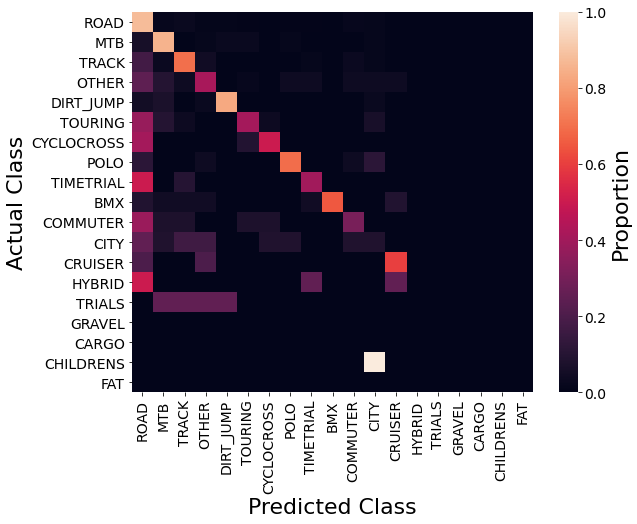

In [16]:
preds=tf.argmax(input=bestdnn.predict(dtest), axis=1).numpy()[np.newaxis].T
# preds=tf.argmax(input=bestcnn.predict(itest), axis=1).numpy()[np.newaxis].T
# preds=tf.argmax(input=bestcomb.predict(combtest), axis=1).numpy()[np.newaxis].T
mat=sklearn.metrics.confusion_matrix(ytest, preds, labels=range(19), sample_weight=None, normalize='true')
matdf=pd.DataFrame(mat, index=classes, columns=classes)
matdf=matdf[orderedclasses]
matdf=matdf.reindex(orderedclasses)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('axes', labelsize=22)     # fontsize of the axes title

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(ax=ax, data=matdf, cbar_kws={'label': 'Proportion'})
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [11]:
shap.initjs()

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


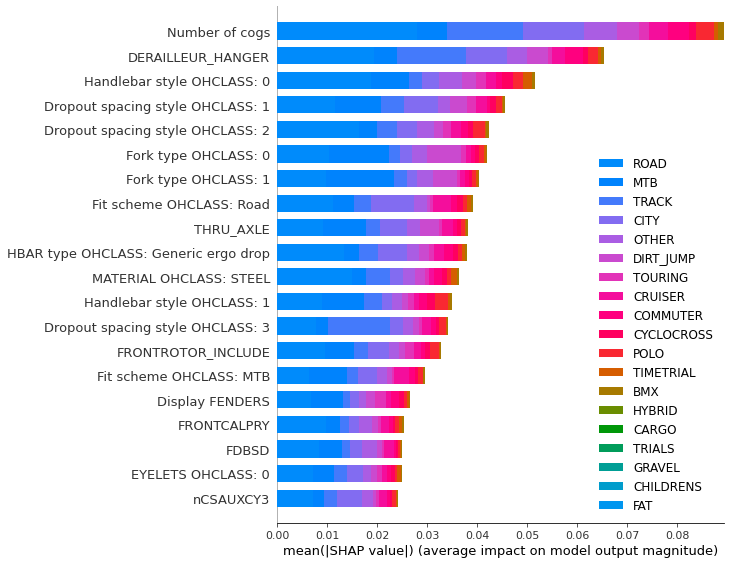

In [17]:
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough
explainer = shap.DeepExplainer(bestdnn,dtrain.iloc[:500,:].values)
shap_values = explainer.shap_values(dtrain.iloc[500:1000,:].values)
shap.summary_plot(shap_values, dtrain, class_names=sorted(reduced["BIKESTYLE"].unique()))

Number of cogs
Fork straight blade
FRONTBRAKE_INCLUDE
DERAILLEUR_HANGER
MATERIAL OHCLASS: STEEL
Dropout spacing style OHCLASS: 1
Dropout spacing style OHCLASS: 2
Dropout spacing style OHCLASS: 3
Fork type OHCLASS: 0
Fork type OHCLASS: 1
Fit scheme OHCLASS: Cyclocross
Fit scheme OHCLASS: Road
Handlebar style OHCLASS: 0
Handlebar style OHCLASS: 1


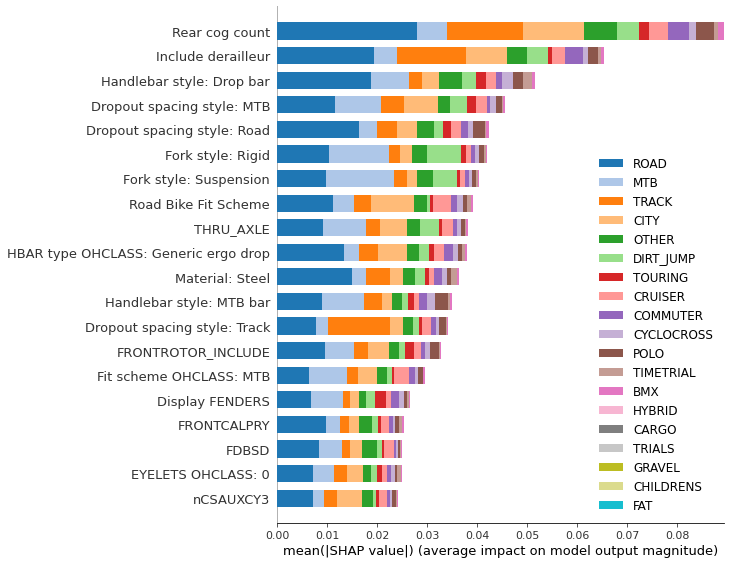

In [21]:
#Ganerate a better shap plot

feature_names=list(dtest.columns)

#Translate some common parameters into clearer terminology
transdict={
    "Number of cogs": "Rear cog count",
    "MATERIAL OHCLASS: STEEL": "Material: Steel",
    "DERAILLEUR_HANGER": "Include derailleur",
    "Handlebar style OHCLASS: 1": "Handlebar style: MTB bar",
    "Handlebar style OHCLASS: 0": "Handlebar style: Drop bar",
    "Fork type OHCLASS: 0": "Fork style: Rigid",
    "Fork type OHCLASS: 1": "Fork style: Suspension",
    "Fork straight blade": "Straight fork",
    "Dropout spacing style OHCLASS: 2": "Dropout spacing style: Road",
    "Dropout spacing style OHCLASS: 1": "Dropout spacing style: MTB",
    "Dropout spacing style OHCLASS: 3": "Dropout spacing style: Track",
    "FRONTBRAKE_INCLUDE": "Include Front Brake",
    "Fit scheme OHCLASS: Cyclocross": "Cyclocross Bike Fit Scheme",
    "Fit scheme OHCLASS: Road": "Road Bike Fit Scheme"
}
for i in range(len(feature_names)):
    if feature_names[i] in transdict:
        print(feature_names[i])
        feature_names[i]=transdict[feature_names[i]]   
shap.summary_plot(shap_values, dtrain, feature_names=feature_names, class_names=sorted(reduced["BIKESTYLE"].unique()),color=plt.get_cmap("tab20"))

In [22]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rc('axes', labelsize=22)     # fontsize of the axes title
plt.rc('axes', titlesize=22) 

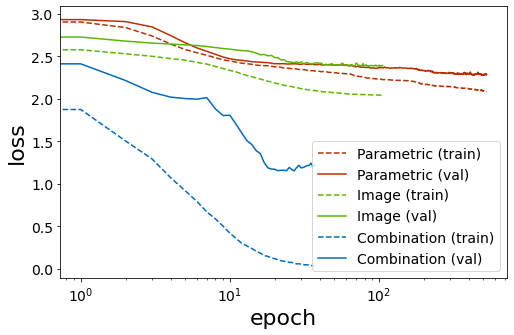

In [23]:
from matplotlib.pyplot import figure
figure(figsize=(8, 5))
plt.plot(dnnhistory.history['loss'],'--',color='#b73000')
plt.plot(dnnhistory.history['val_loss'], color='#b73000')
plt.plot(cnnhistory.history['loss'],'--', color='#5ab700')
plt.plot(cnnhistory.history['val_loss'], color='#5ab700')
plt.plot(combhistory.history['loss'],'--', color='#006ab7')
plt.plot(combhistory.history['val_loss'], color='#006ab7')
plt.xscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Parametric (train)', 'Parametric (val)', 'Image (train)', 'Image (val)', 'Combination (train)', 'Combination (val)'], loc='lower right')
plt.show()

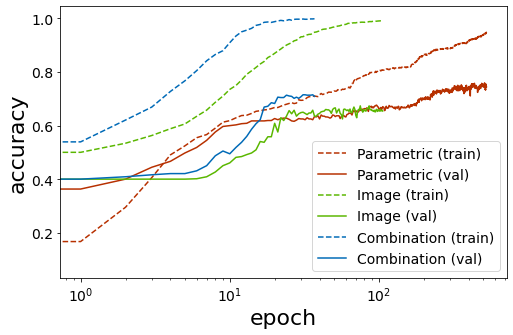

In [24]:
from matplotlib.pyplot import figure
figure(figsize=(8, 5))
plt.plot(dnnhistory.history['accuracy'],'--', color='#b73000')
plt.plot(dnnhistory.history['val_accuracy'], color='#b73000')
plt.plot(cnnhistory.history['accuracy'],'--', color='#5ab700')
plt.plot(cnnhistory.history['val_accuracy'], color='#5ab700')
plt.plot(combhistory.history['accuracy'],'--', color='#006ab7')
plt.plot(combhistory.history['val_accuracy'], color='#006ab7')
plt.xscale('log')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Parametric (train)', 'Parametric (val)', 'Image (train)', 'Image (val)', 'Combination (train)', 'Combination (val)'], loc='lower right')
plt.show()